In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import sys, os, time
from sv_algorithm import IntensityClustering
import cProfile, pstats, StringIO
sys.path.insert(0, '../code/')
import transformation
from helper_functions import hmdb_analysis

# Profiling stuff
pr = cProfile.Profile()
pr.enable()

# The path where data files live: currently, it is in grandparent_folder/data/<file>.csv
grandparent_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
data_dir = grandparent_dir + '/data/'
data_file = 'Urine_37_fullscan1_POS.csv'
file_path = data_dir + data_file

# Path where transformation files live
transformation_folder = os.path.normpath(os.getcwd() + os.sep + os.pardir) + '/dbs/'
transformation_file = 'pos_transformations_camra.yml'
transformation_path = transformation_folder + transformation_file

print ("\nLoading transformations from:\n" + transformation_path + "...\n")
transformations = transformation.load_from_file(transformation_path)
print ("\nLoaded " + str(len(transformations)) + " transformations.")


Loading transformations from:
/home/simonas/Dropbox/University/Project/Coding/ms1fun/dbs/pos_transformations_camra.yml...

Charge Probabilities
+K: 0.200
+2H: 0.100
+H: 0.500
+Na: 0.200

Adduct Probabilities
-CO: 0.071
+CH2O2: 0.071
none: 0.357
+ACN: 0.071
-C2H2: 0.071
-CH2O2: 0.071
+CH3OH: 0.071
-NH3: 0.071
-H2O: 0.071
+NH3: 0.071

Isotope Probabilities
C13: 0.154
mono: 0.769
2C13: 0.077

Multiplicity Probabilities
1: 0.909
2: 0.091

Loaded 150 transformations.


In [2]:
# Initialises an object that loads peaks from a file and gives the RT threshold in seconds
cluster = IntensityClustering(file_path, transformations, rt_thresh=2, tolerance=10)


Creating peaks from a file at: 
/home/simonas/Dropbox/University/Project/Coding/data/Urine_37_fullscan1_POS.csv...

7733 peaks loaded!


In [3]:
# Taking most intense peak, figuring out the groups around it (within given RT window)
print ("Processing...")
start_time = time.clock()
groups = cluster.heavylifting()
end_time = time.clock()
print ("Data processing time: " + str(end_time-start_time))

Processing...
Data processing time: 304.531214


In [5]:
# Write out the results to a file. Top voted group presented at the top.
groups = sorted(groups, key=lambda x: x.vote, reverse=True)
output_dir = grandparent_dir + '/output/'
output_file = 'Urine_37_fullscan1_POS_by_vote.txt'
output_path = output_dir + output_file

with open(output_path, 'w') as f:
    for group in groups:
        line = "vote: {}, M: {}\n".format(group.vote, group.M)
        f.write(line)
        line = '\tPeak m/z,Peak rt,Peak intensity,transformation (transformed mass,vote)\n'
        f.write(line)
        # members = (peak, transformation, transformed_mass); x[1] = list(transformation)
        for (peak, transformation, transformed_mass) in sorted(group.members, key=lambda x: x[1].vote, reverse=True):
            line = "\t{:.4f},{:.4f},{:.2e},{} ({:.4f},{:.4f})\n".format(peak.mass, peak.rt, peak.intensity,
                    transformation, transformed_mass, transformation.vote)
            f.write(line)
        f.write('\n')

print ("\nOutput file has been prepared:\n{}".format(output_path))
print ("Total groups found: " + str(len(groups)))


Output file has been prepared:
/home/simonas/Dropbox/University/Project/Coding/output/Urine_37_fullscan1_POS_by_vote.txt
Total groups found: 5646


Loaded 41514 molecules from ../dbs/hmdb.txt
Number of raw hits (i.e. comparing all peaks): 2806 (36% of peaks)
Number of group hits (i.e. hits on group Ms): 2085 (37% of groups)


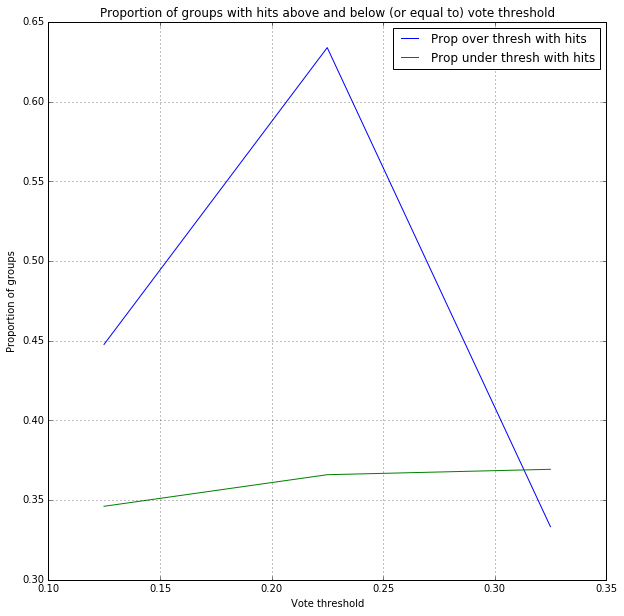

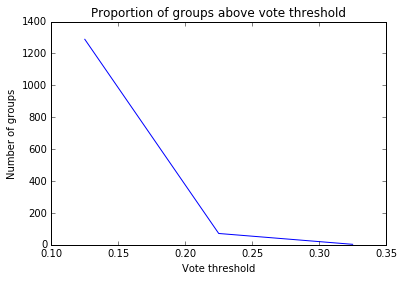

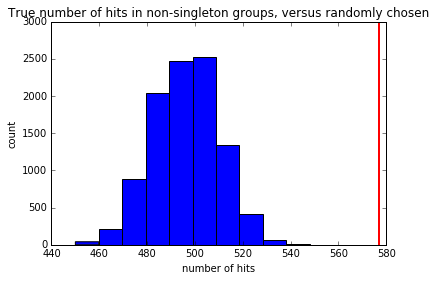

In [6]:
# v_thresh = np.arange(0.1249,0.35,0.1). However: numpy documentations advises against using arange with non-integer 
# steps, as this could lead to inconsistent results.

counts = hmdb_analysis(groups, filename=output_file[:-4])

In [7]:
# Command line printing
# for group in groups:
#     print group

# Profiling continued
pr.disable()
s = StringIO.StringIO()
ps = pstats.Stats(pr, stream=s).sort_stats('time')
ps.print_stats()
print s.getvalue()

         883888689 function calls (883874163 primitive calls) in 472.612 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1  240.314  240.314  303.270  303.270 sv_algorithm.py:132(heavylifting)
       12  144.392   12.033  144.392   12.033 {zmq.backend.cython._poll.zmq_poll}
760709319   29.789    0.000   29.789    0.000 {abs}
 42345000   27.090    0.000   29.296    0.000 ../code/transformation.py:24(reversetransform)
    26758   11.655    0.000   11.655    0.000 ../code/databases.py:45(<genexpr>)
    10000    9.780    0.001   11.361    0.001 /usr/lib/python2.7/random.py:277(shuffle)
 43215262    2.958    0.000    2.958    0.000 {method 'append' of 'list' objects}
 33760000    1.580    0.000    1.580    0.000 {method 'random' of '_random.Random' objects}
   372457    0.680    0.000    0.718    0.000 sv_algorithm.py:59(recalculate)
   634056    0.577    0.000    0.617    0.000 ../code/transformation.py:16(transform)
  